In [5]:
import pandas as pd
import numpy as np

Read data

In [6]:
df = pd.read_csv('data/project_mens_train_file.csv')

Quick preprocessing steps for column names; replace . with _ for better working with columns in Python. 

In [7]:
columns_list = df.columns
new_cols = [i.replace('.', '_') for i in columns_list]
df = df.rename(dict(zip(columns_list, new_cols)), axis=1)
df = df.drop(['train', 'id'], axis=1)

# Data Exploration

Use the amazing pandas profiling library in order to get a feel for the data. 

In [8]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)

In [9]:
# profile

---

# Correlation
Determine correlation between features and target classes. Specifically look at which features are highly correlated to outcome

### Correlation Preprocessing

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# map target class to something more meaningful
def map_outcome_to_binary_names(word):
    if word == 'UE':
        return 'is_unforced_error'
    if word == 'FE':
        return 'is_forced_error'
    if word == 'W':
        return 'is_winner'

In [12]:
# put mapping in label name variable
df['label_name'] = df['outcome'].apply(lambda x: map_outcome_to_binary_names(x))

In [13]:
# create  binary labels and join into original df
dummy_labels = pd.Series(df['label_name']).str.get_dummies()
df = df.join(dummy_labels)

### Correlation Visualisation

In [14]:
# determine columns which I want to visualise; only visualise numeric variables
columns_to_visualise = list(
    pd.DataFrame(df.dtypes) # determine types of df
    .rename({0: 'type'}, axis=1) # rename column to type
    .query('type != "object"') # get all non-string columns (meaning numeric)
    .index # get the name of the column
) 

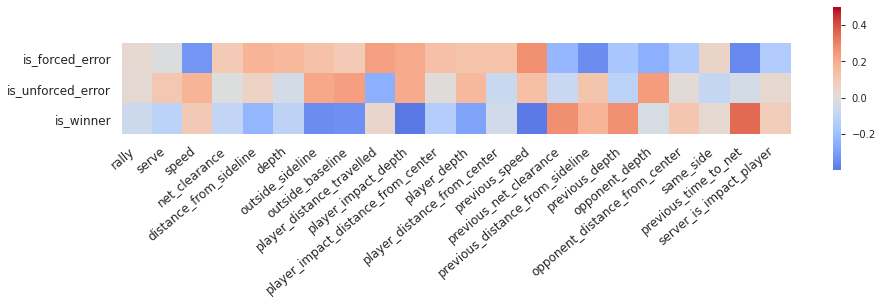

In [15]:
remove_vars = ['serve']
response_vars = ['is_forced_error', 'is_unforced_error', 'is_winner']


corrmat = df[columns_to_visualise].corr()
f, ax = plt.subplots(figsize=(15, 10))
heatmap = sns.heatmap(
    corrmat.loc[~corrmat.index.isin(response_vars),
                response_vars].T, 
    vmax=0.5, square=True, center = 0,
    cbar_kws={'shrink': 0.3},
    cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(),
                        rotation=40, fontsize=12, 
                        ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), 
                        rotation=0, fontsize=12)
plt.show()

**Intepretation**: This is very insightful. Squares towards blue colors indicate that features are negatively correlated with our target classes. Squares towards red highlight positively correlated features with target classes. The stronger the colours, the higher the positive/negative correlation. This already gives an indication of what makes up a each target class. Here are my takeaways from this:
- Forced errors: 
    - Low speed of current shot
    - High speed of previous shot
    - Low distance from sideline of previous shot
    - Low time for previous shot to pass the net
- Unforced errors: 
    - High speed, landing outside side and base line
    - Low distance of player travelled
    - High distance of opponent from net for previous shot
- Winner
    - Medium-high speed
    - Low distance from sidelines
    - Negative correlation of outside sideline and baseline (meaning shot is in)
    - Low distance from net when making winner
    - Low previous speed
    - High net clearance
    - High distance from opponent from net
    - Long previous time to net
    
Additionally, what we can take from this is that it will be relatively easy for the algorithm to classify a winner vs forced/unforced error. The becomes clear when looking at the correlation colours. One can observe that correlations for winners vs. forced/unforced errors are in contrary directions (e.g. if positive for winner, then negative for forced/unforced errors.

---

# Density Plots
From the correlations above, we want to further examine the relationship of some features and the target classes. Specifically, we want to create plots for:
- speed
- previous_speed
- distance_from_sideline
- player_distance_travelled
- previous_distance_from_sideline
- previous_time_to_net
- previous_time_to_net
- opponent_depth




In [16]:
import plotnine as p9

In [17]:
def plot_density_graph(x_axis_var):
    title = 'Density plot for feature {}'.format(x_axis_var)
    
    gg = (
        p9.ggplot(
            df, 
            p9.aes(x = x_axis_var, fill = 'label_name')) 
            + p9.geom_density(alpha = 0.4)
            + p9.scale_x_continuous() 
            + p9.labs(x = x_axis_var, 
                      y = 'density', 
                      title = title)
            + p9.theme(figure_size=(6, 3))
        
    )
    gg.draw()
    plt.show()
    return gg

In [18]:
# determine features that we want to visualise
features_to_vis = [
    'net_clearance',
    'speed',
    'previous_speed',
    'distance_from_sideline',
    'player_distance_travelled',
    'previous_distance_from_sideline',
    'previous_time_to_net',
    'opponent_depth'
]

Plotting feature net_clearance


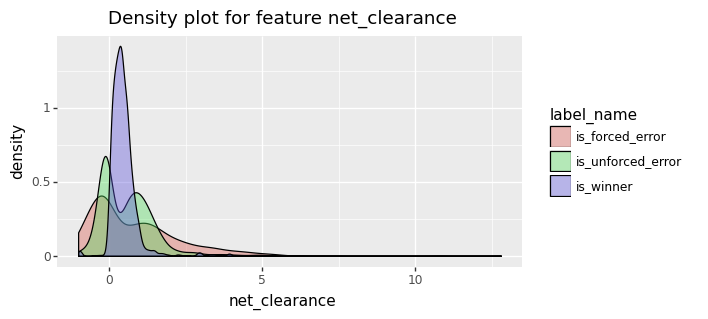

Plotting feature speed


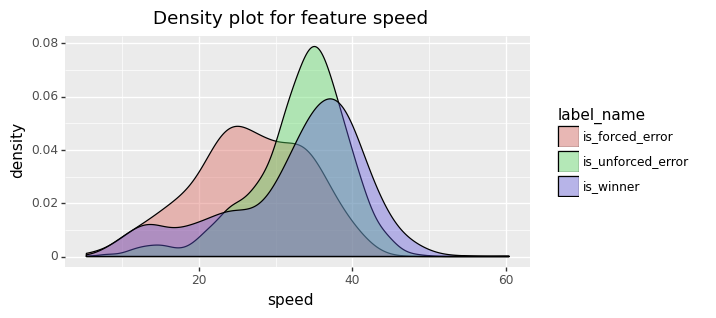

Plotting feature previous_speed


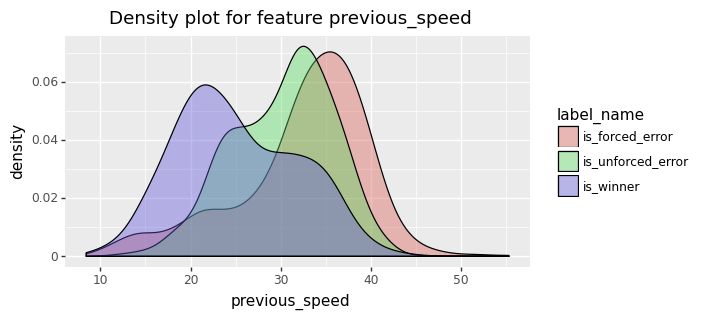

Plotting feature distance_from_sideline


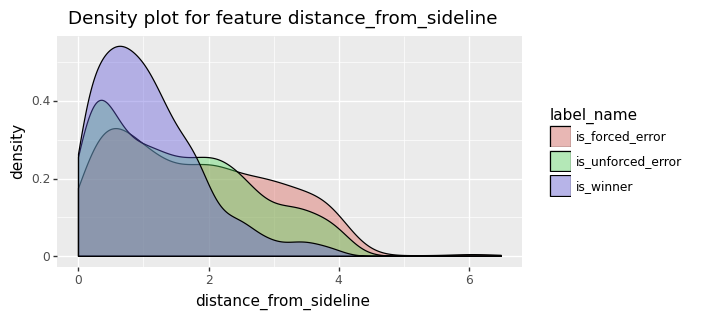

Plotting feature player_distance_travelled


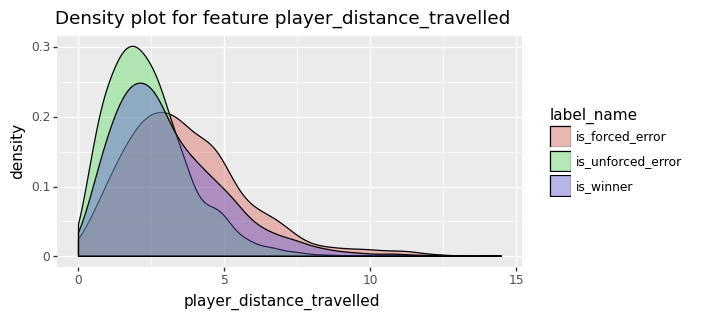

Plotting feature previous_distance_from_sideline


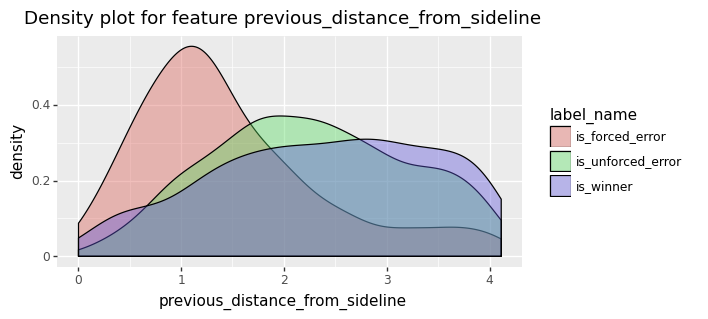

Plotting feature previous_time_to_net


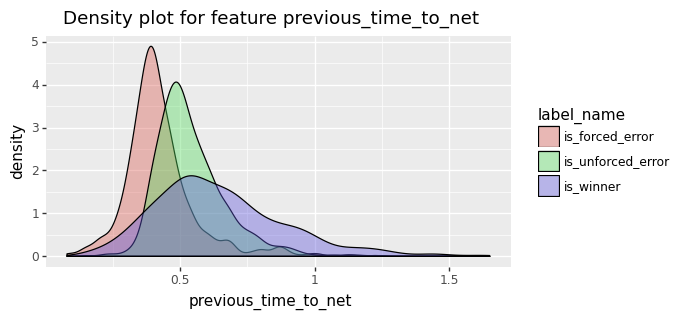

Plotting feature opponent_depth


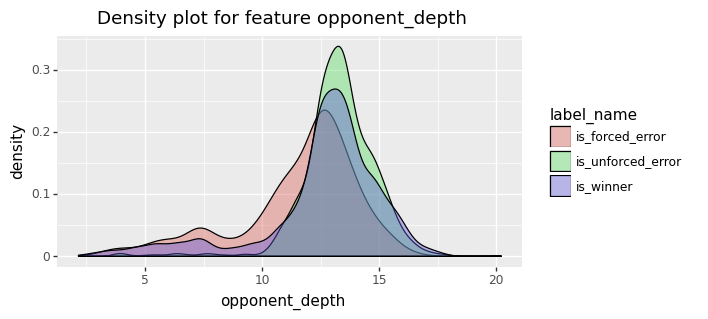

In [50]:
# create density plots for the features described above
for feature in features_to_vis: 
    print(f'Plotting feature {feature}')
    plot_density_graph(x_axis_var=feature)

---

# Tennis Court Visualisation
The great thing about the coordinates is that it is possible to visually plot them on a tennis court. The only disadvantage of this is that it is that that we only know the absolute positive values for values. Therefore, we cannot distinguish between fore and backhand side. 

In [20]:
def add_lines_to_axes_object(ax):
        plt.rcParams['axes.facecolor'] = '#5BC236'

        # Baselines
        ax.plot([-5.485, 5.485], [11.885, 11.885], c='w', linewidth=2)

        # Middleline
        ax.plot([-5.485, 5.485], [0, 0], c='w')

        # Serve T parallel to Middleline
        ax.plot([-4.125, 4.125], [6.4, 6.4], c='w')

        # Serve T
        ax.plot([0, 0], [6.4, 0], c='w')

        # Sidelines
        ax.plot([5.485, 5.485], [11.885, 0], c='w')
        ax.plot([-5.485, -5.485], [11.885, 0], c='w')
        ax.plot([4.125, 4.125], [11.885, 0], c='w')
        ax.plot([-4.125, -4.125], [11.885, 0], c='w')

        return ax

In [24]:
def create_tennis_court_visualisation(x_var, y_var, target_class, ax):
    df_temp = df.query('label_name == "{}"'.format(target_class))
    bounce_colors = df_temp['label_name'].replace({'is_forced_error': 'yellow', 'is_unforced_error': 'red', 'is_winner': 'green'})
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax = add_lines_to_axes_object(ax)
    obj = ax.scatter(
            df_temp[x_var], 
            df_temp[y_var], 
            zorder=100, 
            c=bounce_colors, 
            s=90,
            edgecolors='black',
            linewidths=0.7)
    ax.set_title(f'{to_vis}', fontsize=16, pad=15)

In [40]:
# convert distance from sideline into actual x coordinates; required because they are measured as from single lines and baseline
df['x_coordinates_bounce'] = 4.125 - df['distance_from_sideline']
df['y_coordinates_bounce'] = 11.885 - df['depth']

Ending shot bounce

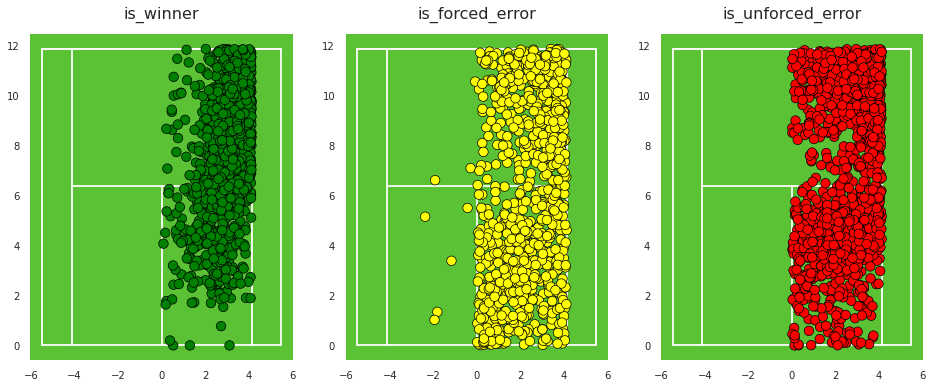

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, to_vis in enumerate(['is_winner', 'is_forced_error', 'is_unforced_error']):
    create_tennis_court_visualisation('x_coordinates_bounce', 'y_coordinates_bounce', to_vis, ax[i])

Positioning on court of player who made ending shot at the time the ending shot was made

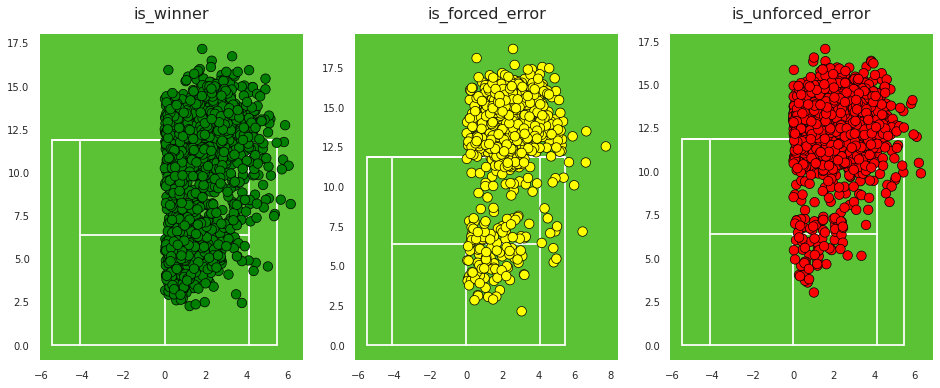

In [45]:
# No need for adjustment of x and y since they are measured as from center and from net
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, to_vis in enumerate(['is_winner', 'is_forced_error', 'is_unforced_error']):
    create_tennis_court_visualisation('player_impact_distance_from_center', 'player_impact_depth', to_vis, ax[i])

Positioning of the player when the second last shot was made

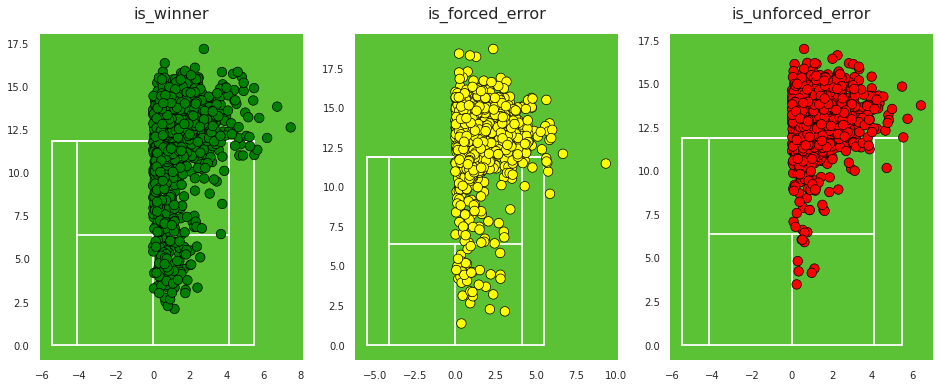

In [46]:
# No need for adjustment of x and y since they are measured as from center and from net
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, to_vis in enumerate(['is_winner', 'is_forced_error', 'is_unforced_error']):
    create_tennis_court_visualisation('player_distance_from_center', 'player_depth', to_vis, ax[i])

Positioning of opponent when he made the second last shot

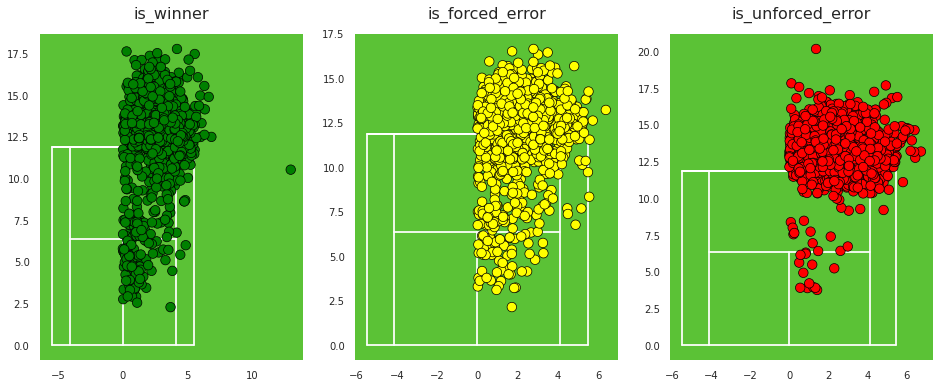

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, to_vis in enumerate(['is_winner', 'is_forced_error', 'is_unforced_error']):
    create_tennis_court_visualisation('opponent_distance_from_center', 'opponent_depth', to_vis, ax[i])

Bounce coordinates of second last bounce

In [48]:
# convert distance from sideline into actual x coordinates; required because they are measured as from single lines and baseline
df['x_coordinates_previous_bounce'] = 4.125 - df['previous_distance_from_sideline']
df['y_coordinates_previous_bounce'] = 11.885 - df['previous_depth']

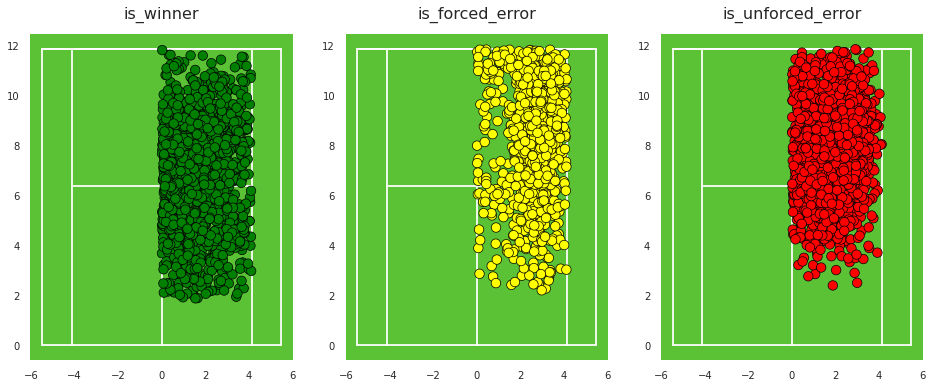

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, to_vis in enumerate(['is_winner', 'is_forced_error', 'is_unforced_error']):
    create_tennis_court_visualisation('x_coordinates_previous_bounce', 'y_coordinates_previous_bounce', to_vis, ax[i])

# Data Checks
We know the clear definition of a winner that the ball must be inside the court, so we can make sure that all data points follow this pattern. 

- Check for outliers in player positioning

# Feature Engineering

- Difference of last shot speed and this shot speed